In [ ]:
# https://www.kaggle.com/humananalog/binary-image-classifier-training-demo

In [1]:
import os
import sys
from PIL import Image
import pandas as pd
import cv2



In [2]:
import numpy as np

In [3]:
import torchvision.transforms as transforms
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [4]:
from torch.autograd import Variable
from torch.utils.data import SubsetRandomSampler
import torchvision.models as models

In [5]:
from tqdm.notebook import tqdm #this import is just a progress bar lol

In [6]:
import matplotlib.pyplot as plt

In [ ]:
from torch.utils.tensorboard import SummaryWriter


In [29]:
#checking for GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

cuda:0


In [16]:
image_size = 224
batch_size = 64

In [17]:
# includes data augementation techniques

# need to fix normalization strategy
transform = transforms.Compose(
    [
#      transforms.ColorJitter(),
     transforms.RandomHorizontalFlip(),
#      transforms.RandomRotation(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# some other data augmentation subs
# https://pytorch.org/docs/stable/torchvision/transforms.html
# torchvision.transforms.RandomApply(transforms, p=0.5) # put transforms in a list to use
# torchvision.transforms.RandomGrayscale(p=0.1)



In [18]:
data_path = '/home/ubuntu/real-and-fake-face-detection/real_and_fake_face/'
dataset = torchvision.datasets.ImageFolder(
    root=data_path,
    transform=transform
)

In [19]:
# creating data indices for training and validation splits
# https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets
validation_split = 0.1
batch_size = 64
shuffle_dataset = True
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
    np.random.seed(42)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

In [20]:
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(val_indices)

In [21]:
# creating pytorch data samplers and loaders
train_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    num_workers=0,
    sampler=train_sampler
)
validation_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    num_workers=0,
    sampler=validation_sampler
)

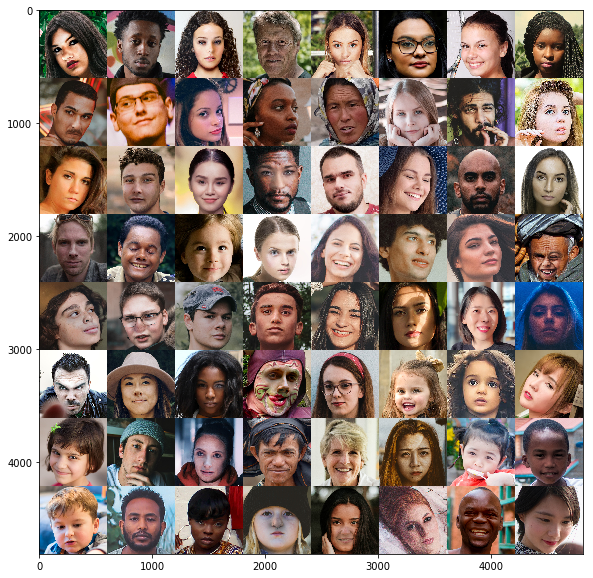

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
plt.figure(figsize=(10,10))
imshow(torchvision.utils.make_grid(images))

In [23]:
# https://www.kaggle.com/humananalog/binary-image-classifier-training-demo
from torchvision.transforms import Normalize

class Unnormalize:
    """Converts an image tensor that was previously Normalize'd
    back to an image with pixels in the range [0, 1]."""
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        mean = torch.as_tensor(self.mean, dtype=tensor.dtype, device=tensor.device).view(3, 1, 1)
        std = torch.as_tensor(self.std, dtype=tensor.dtype, device=tensor.device).view(3, 1, 1)
        return torch.clamp(tensor*std + mean, 0., 1.)


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize_transform = Normalize(mean, std)
unnormalize_transform = Unnormalize(mean, std)

In [26]:
X, y = next(iter(train_loader))

tensor(1)


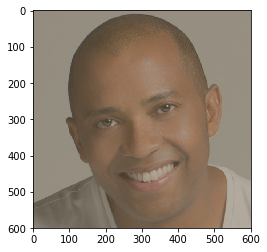

In [45]:
plt.imshow(unnormalize_transform(X[0]).permute(1, 2, 0))
# plt.imshow(X[0].permute(1, 2, 0))
print(y[0])

In [28]:
# first attempting to use ResNeXt50 base model

# Evaluation function for running the model on the validation set:

def evaluate(net, data_loader, device, silent=False):
    net.train(False)
    
    bce_loss = 0
    total_examples = 0
    
    with tqdm(total=len(data_loader), desc="Evaluation", leave=False, disable=silent) as pbar:
        for batch_idx, data in enumerate(data_loader):
            with torch.no_grad():
                batch_size = data[0].shape[0]
                x = data[0].to(device)
                y_true = data[1].to(device).float()
                
                y_pred=net(x)
                y_pred = y_pred.squeeze()
                
                bce_loss += F.binary_cross_entropy_with_logits(y_pred, y_true).item() * batch_size
            
            total_examples += batch_size
            pbar.update()
            
        bce_loss /=total_examples
        
        if silent:
            return bce_loss
        else:
            print("BCE: %.4f" % (bce_loss))
            
            

In [50]:
def fit(epochs):
    global history, iteration, epochs_done, lr
    
    with tqdm(total=len(train_loader), leave=False) as pbar:
        for epoch in range(epochs):
            pbar.reset()
            pbar.set_description("Epoch %d" % (epochs_done +1))
            
            bce_loss = 0
            total_examples = 0
            
            net.train(True)
            
            for batch_idx, data in enumerate(train_loader):
                batch_size = data[0].shape[0]
                
                x = data[0].to(device)
                y_true = data[1].to(device).float()
                
                optimizer.zero_grad()
                
                y_pred = net(x)
                y_pred = y_pred.squeeze()
                
                loss = F.binary_cross_entropy_with_logits(y_pred,y_true)
                
                loss.backward()
                optimizer.step()
                
                batch_bce = loss.item()
                bce_loss += batch_bce *batch_size
                history["train_bce"].append(batch_bce)
                
                total_examples += batch_size
                iteration +=1
                pbar.update()
            
            bce_loss /= total_examples
            epochs_done +=1
            
            print("Epoch: %3d, train BCE: %.4f" % (epochs_done, bce_loss))
            
            val_bce_loss =evaluate(net=net, data_loader=validation_loader,device=device, silent=True)
            history["val_bce"].append(val_bce_loss)
            
            print("             val BCE: %.4f" % (val_bce_loss))
            
            print()

In [51]:

resnext50_32x4d = models.resnext50_32x4d(pretrained=True)

In [52]:
resnext50_32x4d.fc = nn.Linear(2048,1)

In [53]:
net = resnext50_32x4d.to(device)

In [54]:
out = net(torch.zeros((10, 3, image_size, image_size)).to(gpu))
out.shape

torch.Size([10, 1])

In [55]:
# Freezing the early layers of the model
def freeze_until(net, param_name):
    found_name = False
    for name, params in net.named_parameters():
        if name == param_name:
            found_name = True
        params.requires_grad = found_name

In [56]:
freeze_until(net, "layer4.0.conv1.weight")

In [57]:
# train these layers
[k for k,v in net.named_parameters() if v.requires_grad]

['layer4.0.conv1.weight',
 'layer4.0.bn1.weight',
 'layer4.0.bn1.bias',
 'layer4.0.conv2.weight',
 'layer4.0.bn2.weight',
 'layer4.0.bn2.bias',
 'layer4.0.conv3.weight',
 'layer4.0.bn3.weight',
 'layer4.0.bn3.bias',
 'layer4.0.downsample.0.weight',
 'layer4.0.downsample.1.weight',
 'layer4.0.downsample.1.bias',
 'layer4.1.conv1.weight',
 'layer4.1.bn1.weight',
 'layer4.1.bn1.bias',
 'layer4.1.conv2.weight',
 'layer4.1.bn2.weight',
 'layer4.1.bn2.bias',
 'layer4.1.conv3.weight',
 'layer4.1.bn3.weight',
 'layer4.1.bn3.bias',
 'layer4.2.conv1.weight',
 'layer4.2.bn1.weight',
 'layer4.2.bn1.bias',
 'layer4.2.conv2.weight',
 'layer4.2.bn2.weight',
 'layer4.2.bn2.bias',
 'layer4.2.conv3.weight',
 'layer4.2.bn3.weight',
 'layer4.2.bn3.bias',
 'fc.weight',
 'fc.bias']

In [58]:
# pretest of the model
evaluate(net, validation_loader, device=device)

BCE: 0.6915


In [59]:
lr = 0.01
wd = 0.

history = { "train_bce": [], "val_bce": [] }
iteration = 0
epochs_done = 0

optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

In [60]:
# loading from previous checkpoint
# checkpoint = torch.load("model-checkpoint.pth")
# net.load_state_dict(checkpoint)

# checkpoint = torch.load("optimizer-checkpoint.pth")
# optimizer.load_state_dict(checkpoint)

In [61]:
fit(5)

Epoch:   1, train BCE: 0.9535
               val BCE: 0.7281

Epoch:   2, train BCE: 0.7023
               val BCE: 0.7336

Epoch:   3, train BCE: 0.6700
               val BCE: 1.5828

Epoch:   4, train BCE: 0.5168
               val BCE: 1.3261

Epoch:   5, train BCE: 0.4119
               val BCE: 0.3764



In [62]:
# Manual learning rate annealing:

def set_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [63]:
lr /= 10
set_lr(optimizer, lr)

In [64]:
fit(5)

Epoch:   6, train BCE: 0.3120
               val BCE: 0.3231

Epoch:   7, train BCE: 0.2506
               val BCE: 0.2917

Epoch:   8, train BCE: 0.2055
               val BCE: 0.3515

Epoch:   9, train BCE: 0.1527
               val BCE: 0.3884

Epoch:  10, train BCE: 0.1060
               val BCE: 0.4487



In [ ]:
fit(50)

Epoch:  11, train BCE: 0.0790
               val BCE: 0.3987

Epoch:  12, train BCE: 0.0552
               val BCE: 0.4055

Epoch:  13, train BCE: 0.0313
               val BCE: 0.4150

Epoch:  14, train BCE: 0.0219
               val BCE: 0.4577

Epoch:  15, train BCE: 0.0161
               val BCE: 0.5192

Epoch:  16, train BCE: 0.0130
               val BCE: 0.4727

Epoch:  17, train BCE: 0.0125
               val BCE: 0.4664

Epoch:  18, train BCE: 0.0109
               val BCE: 0.4379

Epoch:  19, train BCE: 0.0057
               val BCE: 0.4546

Epoch:  20, train BCE: 0.0066
               val BCE: 0.4936

Epoch:  21, train BCE: 0.0024
               val BCE: 0.4652

Epoch:  22, train BCE: 0.0057
               val BCE: 0.6068

Epoch:  23, train BCE: 0.0074
               val BCE: 0.6103

Epoch:  24, train BCE: 0.0132
               val BCE: 0.9633

Epoch:  25, train BCE: 0.0088
               val BCE: 0.5823

Epoch:  26, train BCE: 0.0080
               val BCE: 0.5859

Epoch:  

In [ ]:
# use Tensorboard
plt.plot(history["train_bce"])


In [ ]:
plt.plot(history["val_bce"])


In [ ]:

checkpoint = { "optimizer": optimizer.state_dict(),
               "model": net.state_dict() }
torch.save(checkpoint, "checkpoint.pth")